In [1]:
import torch
from torch import optim
import torchvision as tv
from jaxtyping import jaxtyped
from beartype import beartype as typechecker
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
import math

## 准备工作

In [ ]:
# 超参数定义
from dataclasses import dataclass
import os

@dataclass
class Config:
    # 文件&数据
    data_path: str = "../dataset/mnist"
    save_dir: str = "./checkpoints"
    save_name: str = "ncsn"
    transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5,), (0.5,))
    ])
    # 训练参数
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    device_id: int = 0
    batch_size: int = 128
    num_workers: int = 4
    lr: float = 1e-4
    epochs: int = 100
    # 模型参数
    channels: int = 1
    image_size: int = 28
    model_dim: int = 64
    num_noise_levels: int = 100
    sigma_max: float = 1.0
    sigma_min: float = 0.01
    anneal_power: float = 2.0
    langevin_steps: int = 20
    langevin_step_size: float = 2e-5

g_opt = Config()
os.makedirs(g_opt.save_dir, exist_ok=True)

In [3]:
# 数据集
from torch.utils.data import DataLoader

train_dataset = tv.datasets.MNIST(
    root=g_opt.data_path,
    train=True,
    transform=g_opt.transform,
    download=True
)
test_dataset = tv.datasets.MNIST(
    root=g_opt.data_path,
    train=False,
    transform=g_opt.transform,
    download=True
)
print(f"共有{len(train_dataset)}张训练图片，{len(test_dataset)}张测试图片")
# 数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=g_opt.batch_size,
    shuffle=True,
    num_workers=g_opt.num_workers,
    pin_memory=True
)
val_loader = DataLoader(
    test_dataset,
    batch_size=g_opt.batch_size,
    shuffle=False,
    num_workers=g_opt.num_workers,
    pin_memory=True,
)


共有60000张训练图片，10000张测试图片


## 模型定义

### Unet

In [4]:
# ----------------------------------------------------
# 1. 位置/时间嵌入模块
# ----------------------------------------------------
class SinusoidalPositionEmbeddings(nn.Module):
    """
    将标量时间步长 t 转换为一个固定维度的向量。
    来自 "Attention Is All You Need" 论文。
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, time):
        # time: [batch_size, 1]
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
# ----------------------------------------------------
# 2. 构成U-Net的基本模块
# ----------------------------------------------------
class ResnetBlock(nn.Module):
    """
    一个包含两个卷积层、组归一化、激活函数和时间嵌入的残差块。
    """
    def __init__(self, in_channels, out_channels, *, time_emb_dim=None, groups=8):
        super().__init__()
        
        # 时间嵌入的线性层
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, out_channels))
            if time_emb_dim is not None
            else None
        )
        # 第一个卷积块
        self.block1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(groups, out_channels)
        self.act1 = nn.SiLU()
        # 第二个卷积块
        self.block2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(groups, out_channels)
        self.act2 = nn.SiLU()
        # 残差连接的卷积层 (如果输入输出通道数不一致)
        self.res_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )
    def forward(self, x, time_emb=None):
        h = self.block1(x)
        h = self.norm1(h)
        h = self.act1(h)
        # 注入时间信息
        if self.mlp is not None and time_emb is not None:
            time_info = self.mlp(time_emb)
            # 将 [batch_size, out_channels] 扩展为 [batch_size, out_channels, 1, 1] 以便相加
            h = h + time_info.unsqueeze(-1).unsqueeze(-1)
        
        h = self.block2(h)
        h = self.norm2(h)
        h = self.act2(h)
        
        return h + self.res_conv(x)
# ----------------------------------------------------
# 3. 完整的 U-Net 模型
# ----------------------------------------------------
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 2),
        channels=1,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()
        # --- 设置维度 ---
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)
        
        init_dim = init_dim if init_dim is not None else dim
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding=3)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        # --- 时间嵌入 ---
        time_dim = dim * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )
        
        # --- U-Net 层 ---
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        # --- 下采样（编码器）---
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)
            self.downs.append(
                nn.ModuleList(
                    [
                        ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                        ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                        nn.Conv2d(dim_in, dim_out, 1) if dim_in != dim_out else nn.Identity(),
                        nn.Conv2d(dim_out, dim_out, kernel_size=4, stride=2, padding=1) if not is_last else nn.Conv2d(dim_out, dim_out, 3, padding=1)
                    ]
                )
            )

        # --- 中间瓶颈层 ---
        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.mid_block2 = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

        # --- 上采样（解码器）---
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind >= (num_resolutions - 1)
            self.ups.append(
                nn.ModuleList(
                    [
                        ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                        ResnetBlock(dim_out + dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                        nn.Conv2d(dim_out, dim_in, 1) if dim_in != dim_out else nn.Identity(),
                        nn.ConvTranspose2d(dim_in, dim_in, kernel_size=4, stride=2, padding=1) if not is_last else nn.Conv2d(dim_in, dim_in, 3, padding=1)
                    ]
                )
            )
            
        # --- 输出层 ---
        out_dim = out_dim if out_dim is not None else channels
        self.final_res_block = ResnetBlock(init_dim * 2, init_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.final_conv = nn.Conv2d(init_dim, out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = x_self_cond if x_self_cond is not None else torch.zeros_like(x)
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)
        h = []

        # 下采样和 skip connection
        for block1, block2, res_conv, downsample in self.downs:
            x = block1(x, t)
            h.append(x)
            x = block2(x, t)
            h.append(x)
            x = res_conv(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)
        
        # 上采样、skip connection 和 upsample
        for block1, block2, res_conv, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = res_conv(x)
            x = upsample(x)
            
        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        
        return self.final_conv(x)

### Noise Control Score Networks

In [5]:
class NCSN(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters() # 保存 config 到 hparams
        self.config = config
        
        self.score_net = Unet(
            dim=config.model_dim,
            channels=config.channels,
            dim_mults=(1, 2, 2)
        )
        
        sigmas = torch.exp(torch.linspace(
            math.log(config.sigma_max), 
            math.log(config.sigma_min), 
            config.num_noise_levels
        ))
        self.register_buffer("sigmas", sigmas)
        self.best_val_loss = float('inf')

    def training_step(self, batch, batch_idx):
        samples, _ = batch
        
        # 1. 为 batch 中的每个样本随机选择一个噪声水平
        labels = torch.randint(0, len(self.sigmas), (samples.shape[0],), device=self.device)
        used_sigmas = self.sigmas[labels].view(samples.shape[0], 1, 1, 1)
        
        # 2. 添加噪声
        noise = torch.randn_like(samples)
        perturbed_samples = samples + noise * used_sigmas
        
        # 3. 计算目标分数
        target = -noise / used_sigmas
        
        # 4. 模型预测分数
        scores = self.score_net(perturbed_samples, labels.float())
        
        # 5. 计算损失 (Annealed Denoising Score Matching Loss)
        # (scores - target)^2 在所有维度上求和，然后乘以 sigma^2
        loss = (scores - target) ** 2
        loss = loss.view(loss.shape[0], -1).sum(dim=-1) * (used_sigmas.squeeze() ** self.config.anneal_power)
        loss = loss.mean() / 2.0
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        self.eval()
        samples, _ = batch
        labels = torch.randint(0, len(self.sigmas), (samples.shape[0],), device=self.device)
        used_sigmas = self.sigmas[labels].view(samples.shape[0], 1, 1, 1)
        noise = torch.randn_like(samples)
        perturbed_samples = samples + noise * used_sigmas
        target = -noise / used_sigmas
        scores = self.score_net(perturbed_samples, labels.float())        
        loss = (scores - target) ** 2
        loss = loss.view(loss.shape[0], -1).sum(dim=-1) * (used_sigmas.squeeze() ** self.config.anneal_power)
        loss = loss.mean() / 2.0
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
        

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.config.lr)
        return optimizer

    @torch.no_grad()
    def sample(self, num_samples, image_size, device):
        self.eval()
        
        # 1. 从最高噪声水平开始，初始化随机样本
        samples = torch.randn(
            num_samples, self.config.channels, image_size, image_size, device=device
        ) * self.sigmas[0]
        
        # 2. 退火朗之万动力学采样
        for i, sigma in enumerate(self.sigmas):
            labels = torch.full((num_samples,), i, device=device, dtype=torch.long)
            step_size = self.config.langevin_step_size * (sigma / self.sigmas[-1]) ** 2

            for t in range(self.config.langevin_steps):
                score = self.score_net(samples, labels.float())
                z = torch.randn_like(samples)
                samples = samples + (step_size / 2) * score + torch.sqrt(step_size) * z
            print("Sample", i, "min", samples.min().item(), "max", samples.max().item(), "abs mean", samples.abs().mean().item())
                
        self.train()
        return samples

## 训练循环

In [6]:
# 初始化数据模块和模型
from lightning.pytorch.callbacks import ModelCheckpoint

model = NCSN(config=g_opt)

# 初始化 Trainer
# 如果有GPU，会自动使用
trainer = L.Trainer(
    max_epochs=g_opt.epochs,
    accelerator="auto",
    devices=[3],
    log_every_n_steps=10,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints/",
            filename="best",
            save_top_k=1,
            save_last=True,
            mode="min"
        )
    ]
)

# 开始训练
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data2/ChengJinjun/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul

Epoch 99: 100%|██████████| 469/469 [01:28<00:00,  5.32it/s, v_num=2, train_loss_step=37.10, val_loss_step=35.40, val_loss_epoch=35.60, train_loss_epoch=35.00]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 469/469 [01:28<00:00,  5.28it/s, v_num=2, train_loss_step=37.10, val_loss_step=35.40, val_loss_epoch=35.60, train_loss_epoch=35.00]


## 采样可视化

开始从训练好的模型生成图像...
Sample 0 min -5.410557270050049 max 4.803630352020264 abs mean 1.0667132139205933
Sample 1 min -5.2549872398376465 max 4.5369672775268555 abs mean 1.1131786108016968
Sample 2 min -4.886181831359863 max 4.225457668304443 abs mean 1.1033769845962524
Sample 3 min -5.009572982788086 max 4.187986850738525 abs mean 1.0845791101455688
Sample 4 min -4.370559215545654 max 4.044765949249268 abs mean 1.0694103240966797
Sample 5 min -4.255558967590332 max 4.698792457580566 abs mean 1.0578279495239258
Sample 6 min -4.281439781188965 max 3.6495349407196045 abs mean 1.0441479682922363
Sample 7 min -4.238559722900391 max 3.551910161972046 abs mean 1.0306086540222168
Sample 8 min -4.204292297363281 max 3.3348581790924072 abs mean 1.0108180046081543
Sample 9 min -3.7621545791625977 max 3.5005853176116943 abs mean 1.0057556629180908
Sample 10 min -3.5623488426208496 max 3.1552343368530273 abs mean 0.9979005455970764
Sample 11 min -3.5592329502105713 max 3.134385347366333 abs mean 0.98479

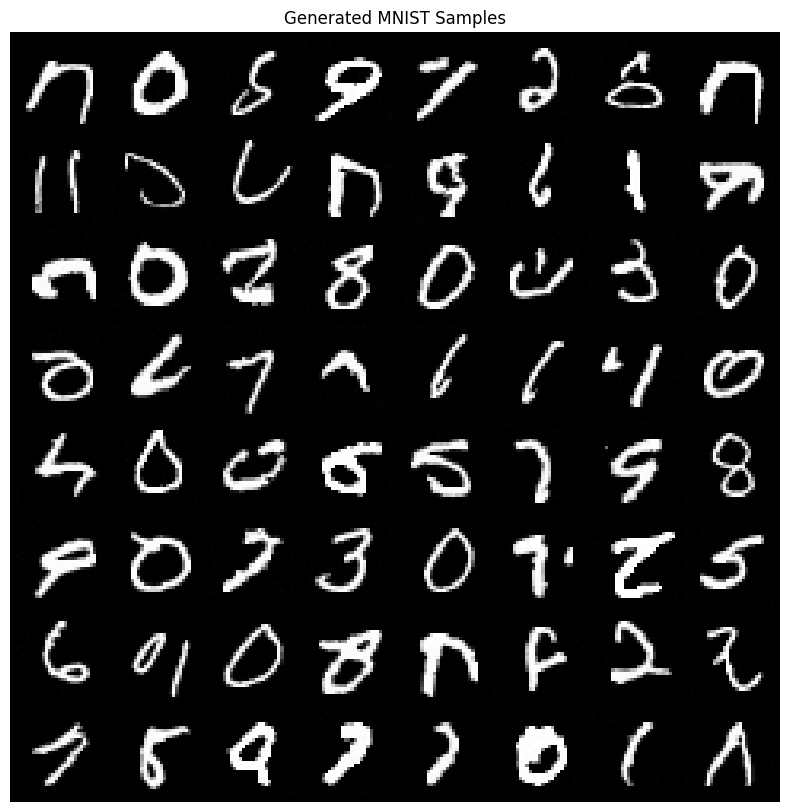

In [7]:
model.to(g_opt.device)

print("开始从训练好的模型生成图像...")
# 生成 64 张图像
samples = model.sample(num_samples=64, image_size=g_opt.image_size, device=g_opt.device)

# 将图像像素值从 [-1, 1] 转换回 [0, 1]
samples = samples * 0.5 + 0.5
samples.clamp_(0, 1)

# 创建图像网格
grid = make_grid(samples, nrow=8, padding=2, normalize=False)

# 显示图像
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title('Generated MNIST Samples')
plt.show()